# Simulating marketing campaign

In this example, we will simulate a competition between two products for gaining popularity on the market - "Drink A" and "Drink B". An attitude of customers to each of them can be binned to the following states: "averse", "neutral", "positive".

Our propagation model will consist of three phases. The first one covers a period when promotion of Drink A becomes more successful than Drink B. The second phase shows a short and intensive campaign against Drink A, when outflow of already propitious individuals should be observed. The last step is a polarisation drift - the neutrality descends and producers utilise individuals averse to the competition in order to attract them to their products.

A purpose of this example is to show that approach of multi-process-spreading implemented in the Network Diffusion is flexible, namely is allows for simple model dynamics.

At first necessary imports. Due to assumed repeatability of the experiment, we will also fix random-number-generators.

In [1]:
import configparser
import os
import random

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

from network_diffusion import (
    MultilayerNetwork,
    MultiSpreading,
    PropagationModel,
)

np.random.seed(123)
random.seed(0)

In [2]:
config = configparser.ConfigParser()
config.read("config.ini")
output_dir = config.get("PATHS", "output_dir")
os.makedirs(output_dir, exist_ok=True)

Then we need to define the network. For the sake of transparency we can visualise it.

In [3]:
network = MultilayerNetwork()
network.load_layer_nx(nx.erdos_renyi_graph(150, 0.025, seed=123), ["drink_a", "drink_b"])

network parameters
--------------------------------------------
general parameters:
	number of layers: 2
	multiplexing coefficient: 1.0

layer 'drink_a' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 150
	number of edges - 306
	average degree - 4.08
	clustering coefficient - 0.0138

layer 'drink_b' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 150
	number of edges - 306
	average degree - 4.08
	clustering coefficient - 0.0138


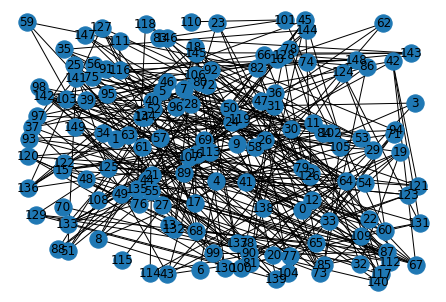

In [4]:
network.describe()
nx.draw(
    network.layers["drink_a"],
    with_labels=True,
    pos=nx.random_layout(network.layers["drink_a"]),
)
plt.show()

General definition of the propagation model. Three states per each process are defined with tiny default weight for each possible transition. The model at this step can be visualised as:
<img src="auxiliaries/general_model.png">

We are also setting up initial states in the network so that for each product 5 individuals are loath, 135 are neutral and 10 are positive.

In [5]:
background_weight = 0.01

phase_1_len = 20
phase_2_len = 10
phase_3_len = 10

model = PropagationModel()
model.add("drink_a", ["averse", "neutral", "positive"])
model.add("drink_b", ["averse", "neutral", "positive"])
model.compile(background_weight=background_weight)

experiment = MultiSpreading(model, network)
experiment.set_initial_states({"drink_a": (5, 135, 10), "drink_b": (5, 135, 10)})

The first phase pf propagation. We are setting up two transition to reflect better campaign of the Drink A than of the Drink B. That can be visualised as:

<img src="auxiliaries/phase_1.png">

The first phase takes 50 epochs.

In [6]:
# set up transitions
model.set_transition_fast("drink_a.neutral", "drink_a.positive", ["drink_b.neutral"], 0.2)
model.set_transition_fast("drink_b.neutral", "drink_b.positive", ["drink_a.neutral"], 0.1)

# perform spreading and save logs
results_phase_1 = experiment.perform_propagation(n_epochs=phase_1_len)
results_phase_1.report(to_file=True, path=f"{output_dir}/phase_1", visualisation=False)

Processing epoch 19: 100%|██████████| 20/20 [00:00<00:00, 51.68it/s]


The second phase pf propagation. We are setting up two transition to reflect rapid campaign against the Drink A. That can be visualised as:

<img src="auxiliaries/phase_2.png">

The second phase takes 10 epochs.

In [7]:
# reset all previous transitions
model.set_transition_fast("drink_a.neutral", "drink_a.positive", ["drink_b.neutral"], background_weight)
model.set_transition_fast("drink_b.neutral", "drink_b.positive", ["drink_a.neutral"], background_weight)

# set up below transitions to obtain effect of negative campaign
model.set_transition_fast("drink_a.neutral", "drink_a.averse", ["drink_b.positive"], 0.3)
model.set_transition_fast("drink_a.neutral", "drink_a.averse", ["drink_b.neutral"], 0.2)
model.set_transition_fast("drink_a.positive", "drink_a.neutral", ["drink_b.neutral"], 0.1)

# perform spreading and save logs
results_phase_2 = experiment.perform_propagation(n_epochs=phase_2_len)
results_phase_2.report(to_file=True, path=f"{output_dir}/phase_2", visualisation=False)

Processing epoch 9: 100%|██████████| 10/10 [00:00<00:00, 39.30it/s]


The third phase pf propagation. We are setting transition to reflect polarisation drift in attitude to both Drink A and B according to diagram below:

<img src="auxiliaries/phase_3.png">

This phase takes 50 epochs.

In [8]:
# reset all previous transitions
model.set_transition_fast("drink_a.neutral", "drink_a.averse", ["drink_b.positive"], background_weight)
model.set_transition_fast("drink_a.neutral", "drink_a.averse", ["drink_b.neutral"], background_weight)
model.set_transition_fast("drink_a.positive", "drink_a.neutral", ["drink_b.neutral"], background_weight)

# attitude to drink_a changes having attitude to drink_b constantly neutral
model.set_transition_fast("drink_a.neutral", "drink_a.positive", ["drink_b.neutral"], 0.2)
model.set_transition_fast("drink_b.neutral", "drink_b.positive", ["drink_a.neutral"], 0.1)

# auxiliary transitions that polarise attitude of the population
model.set_transition_fast("drink_a.neutral", "drink_a.positive", ["drink_b.averse"], 1)
model.set_transition_fast("drink_a.neutral", "drink_a.averse", ["drink_b.positive"], 1)
model.set_transition_fast("drink_b.neutral", "drink_b.positive", ["drink_a.averse"], 1)
model.set_transition_fast("drink_b.neutral", "drink_b.averse", ["drink_a.positive"], 1)

# perform spreading and save logs
results_phase_3 = experiment.perform_propagation(n_epochs=phase_3_len)
results_phase_3.report(to_file=True, path=f"{output_dir}/phase_3", visualisation=False)

Processing epoch 9: 100%|██████████| 10/10 [00:00<00:00, 44.66it/s]


When the simulation is done we are able to visualise result. Instead of plotting a figure for each phase we will prepare one chart.

In [9]:
def prepare_data(drink_name: str) -> pd.DataFrame:
    results = pd.DataFrame()
    for i in ("phase_1", "phase_2", "phase_3"):
        df = pd.read_csv(f"{output_dir}/{i}/drink_{drink_name}_propagation_report.csv")
        results = pd.concat([results, df], ignore_index=True)
    results["epoch"] = np.arange(start=0, stop=len(results), step=1)
    results.set_index("epoch", inplace=True)
    return results

results_a = prepare_data("a")
results_b = prepare_data("b")

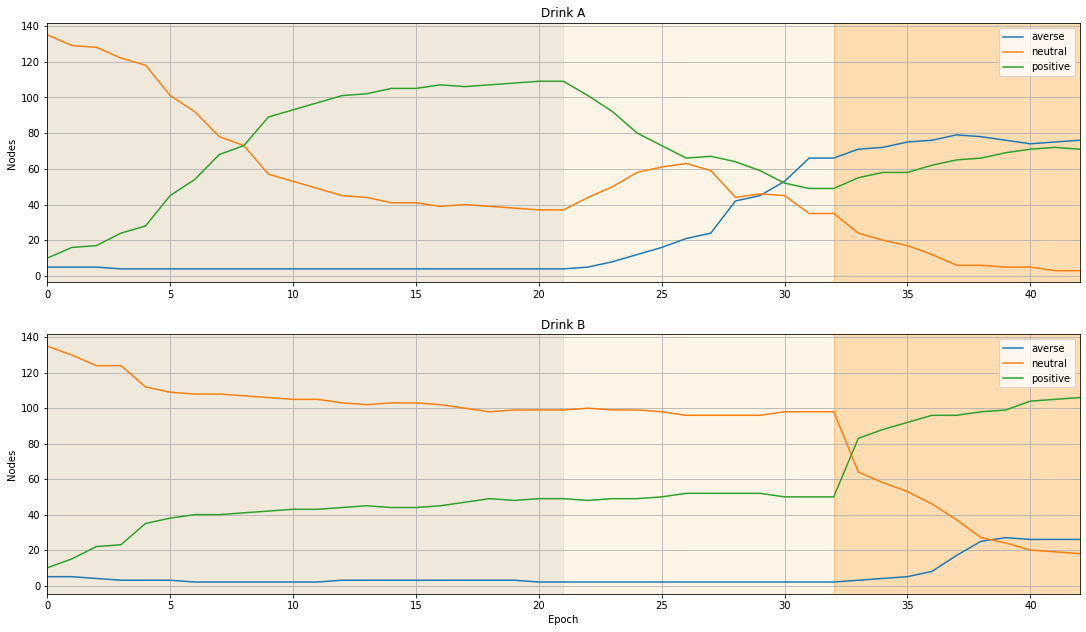

In [10]:
def mark_phases(ax=plt.axes):
    ax.axvspan(0, phase_1_len + 1 , alpha=0.3, color='tan')
    ax.axvspan(phase_1_len + 1, phase_1_len + phase_2_len + 2, alpha=0.3, color='navajowhite')
    ax.axvspan(phase_1_len + phase_2_len + 2, phase_1_len + phase_2_len + phase_3_len + 2, alpha=0.3, color='darkorange')
    ax.set_xlim([0, phase_1_len + phase_2_len + phase_3_len + 2])

fig, ax = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(18.5, 10.5)

results_a.plot(ax=ax[0], legend=True, xlabel="")
ax[0].set_title("Drink A")
ax[0].legend(loc="upper right")
ax[0].set_ylabel("Nodes")
ax[0].grid()
mark_phases(ax[0])

results_b.plot(ax=ax[1], legend=True, xlabel="Epoch")
ax[1].set_title("Drink B")
ax[1].legend(loc="upper right")
ax[1].set_ylabel("Nodes")
ax[1].grid()
mark_phases(ax[1])

plt.show()

As we can see the effect of negative campaign on Drink A is clearly visible - despite that in the phase 1 Drink A gained bigger popularity than its counterpart, during phase 2 changed that trend. It is also seemingful that in the Phase 2 state of Drink B remains constant as described in the model (minor fluctuations are result of the "background weight"). Phase 3 brings (also as assumed) polarisation - state "neutral" decays in favor of its alternatives.